In [24]:
%matplotlib inline

import pdb
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Neural net cost function with regularization

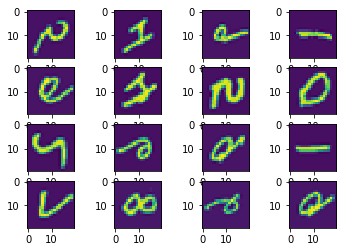

In [37]:
# 5000 Mnist digits
data = loadmat('ex4data1.mat')

# 5000 samples, 500 from each class
num_samples = data['X'].shape[0]

# num of pixels per sample
dim_samples = data['X'].shape[1]

# digits from 0 through 9
num_classes = np.unique(data['y']).size

# randomly select 16 image to display
fig = plt.figure()
for i in range(1, 17):
    index = np.random.randint(low=0, high=4999, size=1)
    image = np.reshape(data['X'][index, :], (20, 20))
    fig.add_subplot(4, 4, i)
    plt.imshow(image)
# end
plt.show()

# load pre-learned weights
weights = loadmat('ex4weights.mat')

# 25x401
theta1 = weights['Theta1']

# 10x26
theta2 = weights['Theta2']
